# Loading Libraries

In [57]:
import numpy as np
import pandas as pd

import time
import sys
import gc
import pickle

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [58]:
from itertools import product
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from IPython import display
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Loading Data

In [59]:
items = pd.read_csv('data/items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 'item_category_id': 'int32'})
shops = pd.read_csv('data/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})
cats = pd.read_csv('data/item_categories.csv', dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
train = pd.read_csv('data/sales_train.csv.gz',
                    parse_dates=['date'],  infer_datetime_format=True, dayfirst=True, 
                    dtype={'date_block_num': 'int32', 'shop_id': 'int32', 
                           'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})
test  = pd.read_csv('data/test.csv.gz', dtype={'ID': 'int32', 'shop_id': 'int32', 'item_id': 'int32'})

In [60]:
print(train.shape)
print(test.shape)

(2935849, 6)
(214200, 3)


# Exploring Data

In [61]:
for df in [items, shops, cats, train, test]:
    display.display(df.head())

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1
1,2013-01-03,0,25,2552,899.00,1
2,2013-01-05,0,25,2552,899.00,-1
3,2013-01-06,0,25,2554,1709.05,1
4,2013-01-15,0,25,2555,1099.00,1


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


Without understanding russian it looks like we have a metacategory for items, and with a research I found that the first word in shops name is the town.

In [62]:
cats['metacategory'] = cats.item_category_name.apply(lambda x: x.split('-')[0])
cats['subcategory'] = cats.item_category_name.apply(lambda x: x.split('-')).map(lambda x:x[1].strip() if len(x)>1 else x[0].strip())

In [63]:
labelencoder = LabelEncoder()
cats["metacategory"] = labelencoder.fit_transform(cats["metacategory"])
cats["subcategory"] = labelencoder.fit_transform(cats["subcategory"])
cats.drop(["item_category_name"], axis=1, inplace=True)
cats.head()

,item_category_id,metacategory,subcategory
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


In [64]:
shops["city"] = shops.shop_name.apply(lambda x: x.replace('!','').split()[0])

In [65]:
shop_groups = shops.shop_name.groupby(shops['city'])

for i,gr in shop_groups : print(i,"\n" ,gr ,"\n")

Адыгея 
 2    Адыгея ТЦ "Мега"
Name: shop_name, dtype: object 

Балашиха 
 3    Балашиха ТРК "Октябрь-Киномир"
Name: shop_name, dtype: object 

Волжский 
 4    Волжский ТЦ "Волга Молл"
Name: shop_name, dtype: object 

Вологда 
 5    Вологда ТРЦ "Мармелад"
Name: shop_name, dtype: object 

Воронеж 
 6      Воронеж (Плехановская, 13)
7          Воронеж ТРЦ "Максимир"
8    Воронеж ТРЦ Сити-Парк "Град"
Name: shop_name, dtype: object 

Выездная 
 9    Выездная Торговля
Name: shop_name, dtype: object 

Жуковский 
 10    Жуковский ул. Чкалова 39м?
11    Жуковский ул. Чкалова 39м²
Name: shop_name, dtype: object 

Интернет-магазин 
 12    Интернет-магазин ЧС
Name: shop_name, dtype: object 

Казань 
 13        Казань ТЦ "Бехетле"
14    Казань ТЦ "ПаркХаус" II
Name: shop_name, dtype: object 

Калуга 
 15    Калуга ТРЦ "XXI век"
Name: shop_name, dtype: object 

Коломна 
 16    Коломна ТЦ "Рио"
Name: shop_name, dtype: object 

Красноярск 
 17    Красноярск ТЦ "Взлетка Плаза"
18             Красноярс

In [66]:
shops["city"] = labelencoder.fit_transform(shops["city"])
shops.drop(['shop_name'], axis=1, inplace=True)
shops.head()

,shop_id,city
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


In [67]:
# Fix ids
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

I'll filter our data to only the ones in the test set, a data leakage per se, that was pointed out in the kernels.

In [68]:
shop_lk = test.shop_id.unique()
item_lk = test.item_id.unique()

train = train[train.shop_id.isin(shop_lk)]
train = train[train.item_id.isin(item_lk)]

We begun our analysis by numerical variables, first lets look at item count and item price in train dataframe.

We can see some outliers for price and count per day, lets remove them.

In [69]:
train = train[train.item_price < 50000]
train = train[train.item_cnt_day < 900]

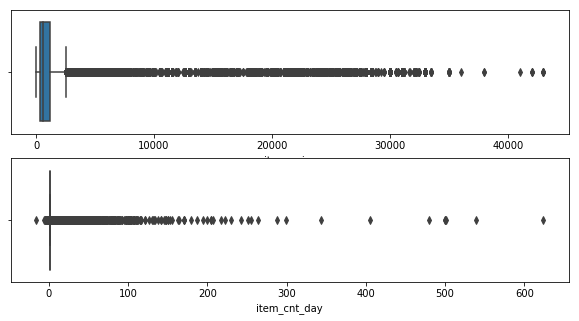

In [70]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,5))
for i, x in enumerate(['item_price', 'item_cnt_day']):
        sns.boxplot(train[x], ax=axes[i])

In [71]:
cols = ['date_block_num','shop_id','item_id']

# For every month we create a grid from all shops/items combinations from that month
df = [] 
for block_num in train['date_block_num'].unique():
    cur_shops = train.loc[train['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = train.loc[train['date_block_num'] == block_num, 'item_id'].unique()
    df.append(np.array(list(product(*[[block_num] ,cur_shops, cur_items])),dtype='int32'))

# Turn the grid into a dataframe
df = pd.DataFrame(np.vstack(df), columns = cols,dtype=np.int32)

In [72]:
df.head()

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2574
2,0,59,2607
3,0,59,2614
4,0,59,2808


In [73]:
df.sort_values(cols,inplace=True)

In [74]:
dftemp = train.groupby(cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})

/home/jader/.local/lib/python3.7/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [75]:
dftemp.columns = [col[0] if col[-1]=='' else col[-1] for col in dftemp.columns.values]

In [76]:
df_all = pd.merge(df, dftemp, how='left', on=cols)
df_all['target'] = df_all['target'].fillna(0).clip(0,20).astype('float16')

In [77]:
del df, dftemp
gc.collect()

130

In [78]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2738805 entries, 0 to 2738804
Data columns (total 4 columns):
date_block_num    int32
shop_id           int32
item_id           int32
target            float16
dtypes: float16(1), int32(3)
memory usage: 57.5 MB


In [79]:
df_all['shop_id'] = df_all['shop_id'].astype(np.int8)
df_all['item_id'] = df_all['item_id'].astype(np.int16)
df_all['date_block_num'] = df_all['date_block_num'].astype(np.int8)

In [80]:
dates = df_all['date_block_num']

last_block = dates.max()

In [81]:
test['date_block_num'] = last_block + 1
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
test['date_block_num'] = test['date_block_num'].astype(np.int8)

In [82]:
df_all = pd.concat([df_all, test], ignore_index=True, sort=False, keys=cols)
df_all.fillna(0, inplace=True)

In [83]:
df_all = pd.merge(df_all, shops, on=['shop_id'], how='left')
df_all = pd.merge(df_all, items, on=['item_id'], how='left')
df_all = pd.merge(df_all, cats, on=['item_category_id'], how='left')

In [84]:
print(df_all.info())
df_all.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2953005 entries, 0 to 2953004
Data columns (total 10 columns):
date_block_num      int8
shop_id             int8
item_id             int16
target              float16
ID                  float64
city                int64
item_name           object
item_category_id    int32
metacategory        int64
subcategory         int64
dtypes: float16(1), float64(1), int16(1), int32(1), int64(3), int8(2), object(1)
memory usage: 163.3+ MB
None


,date_block_num,shop_id,item_id,target,ID,city,item_name,item_category_id,metacategory,subcategory
0,0,2,32,0.00,0.00,0,1+1,40,11,4
1,0,2,33,1.00,0.00,0,1+1 (BD),37,11,1
2,0,2,42,0.00,0.00,0,100 Best romantic melodies (mp3-CD) (Digipack),57,13,8
3,0,2,45,0.00,0.00,0,100 лучших народных песен (mp3-CD) (CD-Digipack),57,13,8
4,0,2,51,0.00,0.00,0,100 лучших произведений классики (mp3-CD) (Dig...,57,13,8


In [85]:
df_all['city'] = df_all['city'].astype(np.int8)
df_all['item_category_id'] = df_all['item_category_id'].astype(np.int8)
df_all['metacategory'] = df_all['metacategory'].astype(np.int8)
df_all['subcategory'] = df_all['subcategory'].astype(np.int8)

In [86]:
df_all.drop(['item_name'] ,axis= 1 , inplace = True)

# Mean encoding and lag features

In [87]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [88]:
def expanding_mean_encoding(all_data, cols, name, lags):
    tmp = all_data.copy()
    cumsum = tmp.groupby(cols)['target'].cumsum() - tmp['target']
    cumcnt = tmp.groupby(cols).cumcount()
    tmp[name] = cumsum/cumcnt
    
    tmp[name] = tmp.groupby(cols)[name].transform(lambda x: x.fillna(x.mean()))
    tmp[name] = tmp[name].astype(np.float32)
    tmp = lag_feature(tmp, lags, name)
    tmp.drop([name], axis=1, inplace=True)
    return tmp

In [89]:
def kfold_mean_encoding(all_data, cols, name, lags):
    tmp = all_data.copy()
    kf = KFold(5, shuffle=False)
    tmp[name] = 0

    for tr_ind, val_ind in kf.split(all_data):
        X_tr, X_val = tmp.iloc[tr_ind], tmp.iloc[val_ind]
        grp = X_tr.groupby(cols).target.mean()
        grp2 = X_val.set_index(cols).index
        tmp.loc[tmp.index[val_ind],name] = grp2.map(grp)

    tmp[name] = tmp[name].astype(np.float16)
    tmp = lag_feature(tmp, lags, name)
    tmp.drop([name], axis=1, inplace=True)
    return tmp

In [90]:
# Make lag encoded features for item_cnt_month
def mean_encoding_lag(matrix, cols, name, lags):
    tmp = matrix.copy()
    group = tmp.groupby(cols).agg({'target': ['mean']})
    group.columns = [name]
    group.reset_index(inplace=True)

    tmp = pd.merge(tmp, group, on=cols, how='left')
    tmp[name] = tmp[name].astype(np.float16)
    tmp = lag_feature(tmp, lags, name)
    tmp.drop([name], axis=1, inplace=True)
    return tmp

In [91]:
df_all['target'] = df_all['target'].astype(np.float16)

In [92]:
df_all = lag_feature(df_all, [1,2,3,6,12], 'target')

In [93]:
df_all = kfold_mean_encoding(df_all, ['date_block_num'], 'date_avg_item_cnt', [1])
df_all = kfold_mean_encoding(df_all, ['date_block_num', 'item_id'], 'date_item_avg_item_cnt', [1,2,3,6,12])
df_all = kfold_mean_encoding(df_all, ['date_block_num', 'shop_id'], 'date_shop_avg_item_cnt', [1,2,3,6,12])
df_all = kfold_mean_encoding(df_all, ['date_block_num', 'item_category_id'], 'date_category_avg_item_cnt', [1])

In [94]:
df_all = kfold_mean_encoding(df_all, ['date_block_num', 'shop_id', 'item_category_id'], 'date_shop_category_avg_item_cnt', [1])
df_all = kfold_mean_encoding(df_all, ['date_block_num', 'shop_id', 'metacategory'], 'date_shop_metacategory_avg_item_cnt', [1])
df_all = kfold_mean_encoding(df_all, ['date_block_num', 'shop_id', 'subcategory'], 'date_shop_subcategory_avg_item_cnt', [1])
df_all = kfold_mean_encoding(df_all, ['date_block_num', 'city'], 'date_town_avg_item_cnt', [1])
gc.collect()

63

In [95]:
df_all = kfold_mean_encoding(df_all, ['date_block_num', 'item_id', 'city'], 'date_item_town_avg_item_cnt', [1])
df_all = kfold_mean_encoding(df_all, ['date_block_num', 'metacategory'], 'date_metacategory_avg_item_cnt', [1])
df_all = kfold_mean_encoding(df_all, ['date_block_num', 'subcategory'], 'date_subcategory_avg_item_cnt', [1])
gc.collect();
df_all.head()

,date_block_num,shop_id,item_id,target,ID,city,item_category_id,metacategory,subcategory,target_lag_1,...,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_category_avg_item_cnt_lag_1,date_shop_category_avg_item_cnt_lag_1,date_shop_metacategory_avg_item_cnt_lag_1,date_shop_subcategory_avg_item_cnt_lag_1,date_town_avg_item_cnt_lag_1,date_item_town_avg_item_cnt_lag_1,date_metacategory_avg_item_cnt_lag_1,date_subcategory_avg_item_cnt_lag_1
0,0,2,32,0.00,0.00,0,40,11,4,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,0,2,33,1.00,0.00,0,37,11,1,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,0,2,42,0.00,0.00,0,57,13,8,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,0,2,45,0.00,0.00,0,57,13,8,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,0,2,51,0.00,0.00,0,57,13,8,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [96]:
df_all['month'] = df_all['date_block_num'] % 12

In [97]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
df_all['days'] = df_all['month'].map(days).astype(np.int8)

In [98]:
df_all['item_shop_first_sale'] = df_all['date_block_num'] - df_all.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
df_all['item_first_sale'] = df_all['date_block_num'] - df_all.groupby('item_id')['date_block_num'].transform('min')

In [99]:
df_all = df_all[df_all.date_block_num > 11]

In [100]:
df_all.fillna(0,inplace = True)

In [101]:
df_all.to_pickle('final.pkl')
del df_all

In [102]:
del items
del shops
del cats
del train
gc.collect();

In [103]:
final = pd.read_pickle('final.pkl')

In [104]:
X_train = final[final.date_block_num < 33].drop(['target'], axis=1)
Y_train = final[final.date_block_num < 33]['target']

X_valid = final[final.date_block_num == 33].drop(['target'], axis=1)
Y_valid = final[final.date_block_num == 33]['target']

X_test = final[final.date_block_num == 34].drop(['target'], axis=1)

In [105]:
del final
gc.collect();

In [106]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.85, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

[0]	validation_0-rmse:1.52494	validation_1-rmse:1.19568
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.45586	validation_1-rmse:1.14626
[2]	validation_0-rmse:1.39776	validation_1-rmse:1.10533
[3]	validation_0-rmse:1.35703	validation_1-rmse:1.07724
[4]	validation_0-rmse:1.31355	validation_1-rmse:1.04844
[5]	validation_0-rmse:1.27655	validation_1-rmse:1.02631
[6]	validation_0-rmse:1.24505	validation_1-rmse:1.00706
[7]	validation_0-rmse:1.21833	validation_1-rmse:0.991639
[8]	validation_0-rmse:1.19949	validation_1-rmse:0.981647
[9]	validation_0-rmse:1.18006	validation_1-rmse:0.972058
[10]	validation_0-rmse:1.16273	validation_1-rmse:0.966869
[11]	validation_0-rmse:1.14949	validation_1-rmse:0.96081
[12]	validation_0-rmse:1.13749	validation_1-rmse:0.955531
[13]	validation_0-rmse:1.12779	validation_1-rmse:0.952352
[14]	validation_0-rmse:1.11884	validation_1-rms

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.85, eta=0.3, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=300, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=0.8)

In [107]:
lg = LGBMRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.85, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

lg.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

[1]	training's rmse: 1.52731	training's l2: 2.33268	valid_1's rmse: 1.19457	valid_1's l2: 1.42699
Training until validation scores don't improve for 10 rounds.
[2]	training's rmse: 1.46371	training's l2: 2.14245	valid_1's rmse: 1.15018	valid_1's l2: 1.32291
[3]	training's rmse: 1.40905	training's l2: 1.98541	valid_1's rmse: 1.1125	valid_1's l2: 1.23766
[4]	training's rmse: 1.36232	training's l2: 1.85592	valid_1's rmse: 1.08201	valid_1's l2: 1.17074
[5]	training's rmse: 1.32479	training's l2: 1.75506	valid_1's rmse: 1.05871	valid_1's l2: 1.12086
[6]	training's rmse: 1.29122	training's l2: 1.66725	valid_1's rmse: 1.03783	valid_1's l2: 1.07709
[7]	training's rmse: 1.26296	training's l2: 1.59506	valid_1's rmse: 1.02098	valid_1's l2: 1.04241
[8]	training's rmse: 1.24428	training's l2: 1.54823	valid_1's rmse: 1.00885	valid_1's l2: 1.01777
[9]	training's rmse: 1.2227	training's l2: 1.49499	valid_1's rmse: 0.995296	valid_1's l2: 0.990613
[10]	training's rmse: 1.20638	training's l2: 1.45534	val

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.85,
       eta=0.3, importance_type='split', learning_rate=0.1, max_depth=8,
       min_child_samples=20, min_child_weight=300, min_split_gain=0.0,
       n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
       silent=True, subsample=0.8, subsample_for_bin=200000,
       subsample_freq=0)

In [108]:
clf = Lasso()
clf.fit(X_train, Y_train)

/usr/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [109]:
Y_pred = model.predict(X_valid).clip(0, 20)
xgb_Y_test = model.predict(X_test).clip(0, 20)
submission = pd.DataFrame({"ID": test.index,"item_cnt_month": xgb_Y_test})
submission.to_csv('xgb_submission.csv', index=False)

In [110]:
Y_pred = lg.predict(X_valid).clip(0, 20)
lgbm_Y_test = lg.predict(X_test).clip(0, 20)
submission = pd.DataFrame({"ID": test.index,"item_cnt_month": lgbm_Y_test})
submission.to_csv('lgbm_submission.csv', index=False)

In [111]:
Y_pred = clf.predict(X_valid).clip(0, 20)
lasso_Y_test = clf.predict(X_test).clip(0, 20)
submission = pd.DataFrame({"ID": test.index,"item_cnt_month": lasso_Y_test})
submission.to_csv('lasso_submission.csv', index=False)

# Ensemble

In [113]:
#linearly combines predictions
final_Y_test = xgb_Y_test*0.75 + lgbm_Y_test*0.2 + lasso_Y_test*0.05
submission = pd.DataFrame({"ID": test.index,"item_cnt_month": final_Y_test})
submission.to_csv('final_submission.csv', index=False)